In [11]:
from astropy.io import fits,ascii
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import sys
import warnings
warnings.filterwarnings('ignore')
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.stats import ks_2samp
from astropy import units as u

In [2]:
sys.path.append('/home/rfinn/github/APPSS/')

In [3]:
from a100sdss import ks, anderson

In [4]:
sys.path.append('/home/rfinn/github/LCS/python/Python3/')

In [5]:
from LCScommon import *

Running on coma


In [6]:
homedir = os.getenv("HOME")

In [26]:
def colormass(x1,y1,x2,y2,name1,name2, figname, hexbinflag=False,contourflag=False, \
             xmin=7.9, xmax=11.6, ymin=-1.2, ymax=1.2, contour_bins = 40, ncontour_levels=5,\
             xlabel='$\log_{10}(M_\star/M_\odot) $', ylabel='$(g-i)_{corrected} $', color2='c',\
             nhistbin=50, alphagray=.1):
    fig = plt.figure(figsize=(8,8))
    nrow = 4
    ncol = 4
    
    # for purposes of this plot, only keep data within the 
    # window specified by [xmin:xmax, ymin:ymax]
    
    keepflag1 = (x1 >= xmin) & (x1 <= xmax) & (y1 >= ymin) & (y1 <= ymax)
    keepflag2 = (x2 >= xmin) & (x2 <= xmax) & (y2 >= ymin) & (y2 <= ymax)
    
    x1 = x1[keepflag1]
    y1 = y1[keepflag1]
    
    x2 = x2[keepflag2]
    y2 = y2[keepflag2]
    
    ax1 = plt.subplot2grid((nrow,ncol),(1,0),rowspan=nrow-1,colspan=ncol-1, fig=fig)
    if hexbinflag:
        #t1 = plt.hist2d(x1,y1,bins=100,cmap='gray_r')
        #H, xbins,ybins = np.histogram2d(x1,y1,bins=20)
        #extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
        #plt.contour(np.log10(H.T+1),  10, extent = extent, zorder=1,colors='k')
        #plt.hexbin(xvar2,yvar2,bins='log',cmap='Blues', gridsize=100)

        plt.hexbin(x1,y1,bins='log',cmap='gray_r', gridsize=75,label=name1)
    else:
        plt.plot(x1,y1,'k.',alpha=alphagray,label=name1, zorder=2)
    if contourflag:
        H, xbins,ybins = np.histogram2d(x2,y2,bins=contour_bins)
        extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]]
        plt.contour((H.T), levels=ncontour_levels, extent = extent, zorder=1,colors=color2, label='__nolegend__')
        #plt.legend()
    else:
        plt.plot(x2,y2,'c.',color=color2,alpha=.3, label=name2)
        
        
        #plt.legend()
    #sns.kdeplot(agc['LogMstarTaylor'][keepagc],agc['gmi_corrected'][keepagc])#,bins='log',gridsize=200,cmap='blue_r')
    #plt.colorbar()
    
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlabel,fontsize=22)
    plt.ylabel(ylabel,fontsize=22)
    #plt.axis([7.9,11.6,-.05,2])
    ax2 = plt.subplot2grid((nrow,ncol),(0,0),rowspan=1,colspan=ncol-1, fig=fig, sharex = ax1, yticks=[])
    t = plt.hist(x1, normed=True, bins=nhistbin,color='k',histtype='step',lw=1.5, label=name1)
    t = plt.hist(x2, normed=True, bins=nhistbin,color=color2,histtype='step',lw=1.5, label=name2)
    #plt.legend()
    ax2.legend(fontsize=10,loc='upper left')
    ax2.xaxis.tick_top()
    ax3 = plt.subplot2grid((nrow,ncol),(1,ncol-1),rowspan=nrow-1,colspan=1, fig=fig, sharey = ax1, xticks=[])
    t=plt.hist(y1, normed=True, orientation='horizontal',bins=nhistbin,color='k',histtype='step',lw=1.5, label=name1)
    t=plt.hist(y2, normed=True, orientation='horizontal',bins=nhistbin,color=color2,histtype='step',lw=1.5, label=name2)
    
    plt.yticks(rotation='horizontal')
    ax3.yaxis.tick_right()
    plt.savefig(figname)

    print('############################################################# ')
    print('KS test comparising galaxies within range shown on the plot')
    print('')
    print('STELLAR MASS')
    t = ks(x1,x2,run_anderson=False)
    print('')
    print('COLOR')
    t = ks(y1,y2,run_anderson=False)



In [27]:
def plotsalim07():
    #plot the main sequence from Salim+07 for a Chabrier IMF

    lmstar=np.arange(8.5,11.5,0.1)

    #use their equation 11 for pure SF galaxies
    lssfr = -0.35*(lmstar - 10) - 9.83

    #use their equation 12 for color-selected galaxies including
    #AGN/SF composites.  This is for log(Mstar)>9.4
    #lssfr = -0.53*(lmstar - 10) - 9.87

    lsfr = lmstar + lssfr -.3
    sfr = 10.**lsfr

    plt.plot(lmstar, lsfr, 'w-', lw=4)
    plt.plot(lmstar, lsfr, c='salmon',ls='-', lw=2, label='$Salim+07$')
    plt.plot(lmstar, lsfr-np.log10(5.), 'w--', lw=4)
    plt.plot(lmstar, lsfr-np.log10(5.), c='salmon',ls='--', lw=2)
        
def plotelbaz():
    #plot the main sequence from Elbaz+13
        
    xe=np.arange(8.5,11.5,.1)
    xe=10.**xe

    #I think that this comes from the intercept of the
    #Main-sequence curve in Fig. 18 of Elbaz+11.  They make the
    #assumption that galaxies at a fixed redshift have a constant
    #sSFR=SFR/Mstar.  This is the value at z=0.  This is
    #consistent with the value in their Eq. 13

    #This is for a Salpeter IMF
    ye=(.08e-9)*xe   
        
        
    plt.plot(log10(xe),np.log19(ye),'w-',lw=3)
    plt.plot(log10(xe),np.log10(ye),'k-',lw=2,label='$Elbaz+2011$')
    #plot(log10(xe),(2*ye),'w-',lw=4)
    #plot(log10(xe),(2*ye),'k:',lw=2,label='$2 \ SFR_{MS}$')
    plt.plot(log10(xe),np.log10(ye/5.),'w--',lw=4)
    plt.plot(log10(xe),np.log10(ye/5.),'k--',lw=2,label='$SFR_{MS}/5$')

In [28]:
def sfr_mstar(flags,colorvar,plotbinned=True,v1=.1,v2=1):

    plt.figure(figsize=(14,4))
    all_axes=[]
    for i in range(len(flags)):
        plt.subplot(1,3,i+1)
        plt.scatter(mstar[flags[i]],sfr[flags[i]],c=colorvar[flags[i]],vmin=v1,vmax=v2)
        if i > 0:
            plt.yticks([])
        plt.axis([8,12,-2,1])
        all_axes.append(plt.gca())
        xl = np.linspace(8,12,100)
        # chi by eye split b/w SF and quiescent
        yl = -11.8 + xl
        plt.plot(xl,yl,'k--')
        # chi by eye fit to main sequence in field
        yl = -10.4 + xl
        plt.plot(xl,yl,'k-')
        if plotbinned:
            xbin,ybin,ybinerr= binxycolor(mstar[flags[i]& sf_flag],sfr[flags[i]& sf_flag],colorvar[flags[i] & sf_flag],6,use_median=True)
 
            plt.scatter(xbin,ybin,c=ybinerr,s=300,vmin=v1,vmax=v2,marker='s')
    plt.colorbar(ax=all_axes)
    
def size_vs_size(flags,colorvar,plotbinned=True,v1=1,v2=10):
    xmin=0
    xmax=15
    plt.figure(figsize=(14,4))
    all_axes=[]
    for i in range(len(flags)):
        plt.subplot(1,3,i+1)
        #plt.scatter(g.s['Rd'][flags[i]],g.s['fre1'][flags[i]],c=colorvar[flags[i]],vmin=v1,vmax=v2)
        plt.scatter(g.s['Rd'][flags[i]],g.s['fre1'][flags[i]],c=colorvar[flags[i]],vmin=v1,vmax=v2)
        if i > 0:
            plt.yticks([])
        plt.axis([xmin,xmax,xmin,xmax])
        #plt.gca().set_xscale('log')
        #plt.gca().set_yscale('log')
        all_axes.append(plt.gca())
        xl = np.linspace(xmin,xmax,100)
        # chi by eye split b/w SF and quiescent
        #yl = -11.8 + xl
        plt.plot(xl,xl,'k--')
        # chi by eye fit to main sequence in field
        #yl = -10.4 + xl
        #plt.plot(xl,yl,'k-')
        if plotbinned:
            xbin,ybin,ybinerr= binxycolor(mstar[flags[i]& sf_flag],sfr[flags[i]& sf_flag],colorvar[flags[i] & sf_flag],6,use_median=True)
 
            plt.scatter(xbin,ybin,c=ybinerr,s=300,vmin=v1,vmax=v2,marker='s')
    plt.colorbar(ax=all_axes)


# Reading in LCSbase #

In [29]:
%run ~/github/LCS/python/Python3/LCSbase.py

nothing happening here
(1800, 1800)
updating table


# Comparison of LCS with GSWLC #

- The GSWLC provides a better comparison sample for us.
- I matched to GSWLC-X2 - used 5 arcsecond radius.  found 1496 matches.
  - I didn't note how I did the match.  I don't see any python programs, so I probably used topcat.
- we can use the GSWLC SFRs and Stellar masses for both the LCS and comparison galaxies.  This removes significant uncertainty associated with mixing methods for calculating SFR and Mstar.

- redshift limit $0.01 < z < 0.3$
- mag limit r petrosian $r = 18.0$
- main sequence: $log10(sSFR) > -11$
- explanation of GSWLC-2 catalog http://pages.iu.edu/~salims/gswlc/table2.pdf

**Stellar Mass Limit **

- convert r to Mr at maximum distance of LCS ($z=.0433$)
- then plot Mstar vs Mr, and estimate Mstar limit from Mr limit

**SFR Limit**
- Salim+2018 use $log10(sSFR) > -11$ to select star-forming galaxies
- $log10(sSFR) < -11.5$ should be considered upper limits GSWLC-A (Salim+2018, pg 11, col2)
  - we use this as our sSFR limit
- for SF galaxies, SFR errors are typically below 0.1dex

**Environment Catalogs**
- yang+07
- tempel+2012 - http://www.aai.ee/~elmo/dr8groups/readme.txt
- decarvalha+2017

In [30]:
# this catalog is a joined catalog between LCS and GSWLC
# it contains 1505 rows - the number of matches b/w the two catalogs
lcsgsw = fits.getdata('/home/rfinn/research/LCS/tables/lcs-gswlc-x2-match.fits')
#lcsgsw['sampleflag'] = lcsgsw['sampleflag'] == 84

In [31]:
print('number of matches between LCS and GSWLC = ',len(lcsgsw))
print('number with UV = ',sum(lcsgsw['flag_uv'] == 2))
print('number with mid IR = ',sum(lcsgsw['flag_midir'] == 1))
print('number with SDSS galaxy data = ',sum(lcsgsw['flag_mgs'] == 1))

number of matches between LCS and GSWLC =  1505
number with UV =  546
number with mid IR =  437
number with SDSS galaxy data =  1477


### DETERMINING STELLAR MASS LIMIT ###


In [32]:
zmax = max(lcsgsw['ZDIST'])
print(zmax)
# assume hubble flow
dmax = zmax*3.e5/70
r_limit = 18.
# abs r
# m - M = 5logd_pc - 5
# M = m - 5logd_pc + 5
## r = 22.5 - np.log10(lcsgsw['NMGY'][:,4])
Mr = r_limit - 5*np.log10(dmax*1.e6) +5
print(Mr)

0.04320573
-18.337822841201557


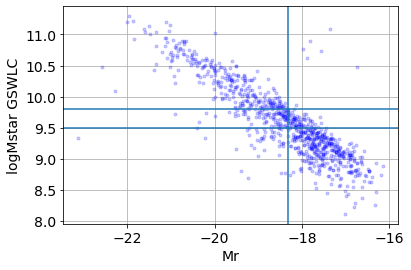

In [33]:
ssfr = lcsgsw['logSFR'] - lcsgsw['logMstar']
flag = (lcsgsw['logMstar'] > 0) & (ssfr > -11.5)
Mr = lcsgsw['ABSMAG'][:,4]
plt.figure()
plt.plot(Mr[flag],lcsgsw['logMstar'][flag],'bo',alpha=.2,markersize=3)
plt.axvline(x=-18.33)
plt.axhline(y=9.8)
plt.xlabel('Mr')
plt.ylabel('logMstar GSWLC')
plt.grid(True)

# SFR - Mstar with GSWLC Values for SFR and Mstar#

* Comparing core and external samples using GSWLC measures of SFR and stellar mass.

* results are sensitive to mass and ssfr cuts.



Text(0.5, 0, 'sSFR')

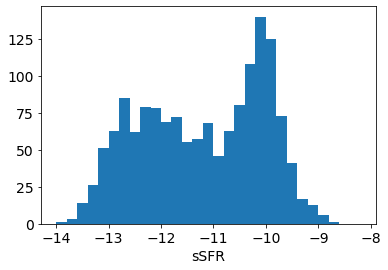

In [47]:
masscut = 9.8
#core = (g.s['DR_R200'] < 0.6) & (g.s['DELTA_V'] < 3.)

mstar = lcsgsw['logMstar']
sfr = lcsgsw['logSFR']
ssfr = sfr - mstar
mybins = np.arange(-14,-8,.2)
t=plt.hist(ssfr,bins=mybins)
plt.xlabel('sSFR')


# Creating Field Sample from Full GSWLC #

* for a quick test, use entire GSWLC catalog
* sort by local density first, then use group catalog from Temple+2014


In [34]:
gsw = ascii.read('/home/rfinn/research/GSWLC/GSWLC-X2.dat')
gsw = gsw[((gsw['Z']*3.e5 < 13000.) & (gsw['logMstar']> 0))] 
print('number is GSWLC = ',len(gsw))

number is GSWLC =  65611


measure local densities

cut GSWLC by local density to create a field sample


could also try matching to Yang catalog - see if it matters.



In [35]:
print(sum(gsw['flag_mgs']))

63521


In [36]:
pos = SkyCoord(ra=gsw['RA']*u.deg,dec=gsw['DEC']*u.deg, distance=gsw['Z']*3.e5/70*u.Mpc,frame='icrs')
NN = 10
idx, d2d, d3d = pos.match_to_catalog_3d(pos,nthneighbor=NN)

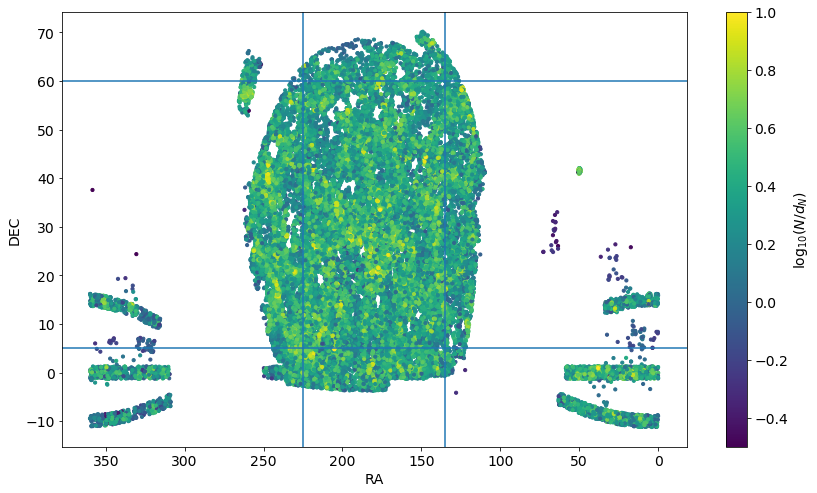

In [37]:
plt.figure(figsize=(14,8))
densN = NN/d3d
plt.scatter(gsw['RA'],gsw['DEC'],c=np.log10(densN*u.Mpc),vmin=-.5,vmax=1.,s=10)
plt.colorbar(label='$\log_{10}(N/d_N)$')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.gca().invert_xaxis()
plt.axhline(y=5)
plt.axhline(y=60)
plt.axvline(x=135)
plt.axvline(x=225)

cutting GSWLC to main SDSS survey area, and then recalculating local densities



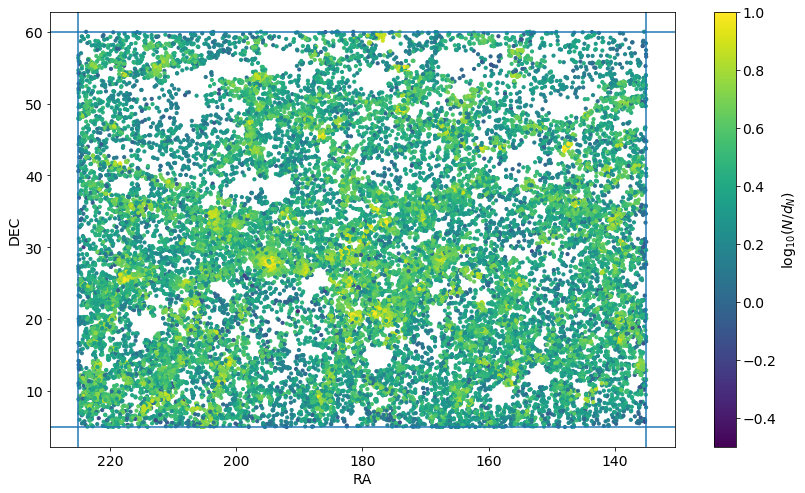

In [41]:
plt.figure(figsize=(14,8))
densN = NN/d3d
plt.scatter(gsw['RA'],gsw['DEC'],c=np.log10(densN*u.Mpc),vmin=-.5,vmax=1.,s=10)
plt.colorbar(label='$\log_{10}(N/d_N)$')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.gca().invert_xaxis()
plt.axhline(y=5)
plt.axhline(y=60)
plt.axvline(x=135)
plt.axvline(x=225)

median local density =  0.488


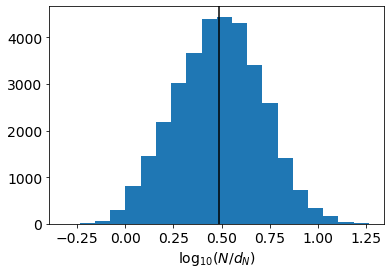

In [42]:
# make a histogram of local densities
plt.figure()
t = plt.hist(np.log10(densN*u.Mpc), bins=20)
plt.xlabel('$ \log_{10} (N/d_N)$')
print('median local density =  %.3f'%(np.median(np.log10(densN*u.Mpc))))
plt.axvline(x = (np.median(np.log10(densN*u.Mpc))),c='k')
gsw_density_flag = np.log10(densN*u.Mpc) < np.median(np.log10(densN*u.Mpc))
gsw_density_flag = np.log10(densN*u.Mpc) < .2

Could also use Yang catalog to remove all galaxies in halos with log M_halo > 13.5 or 14




# Normalization of the main sequence # 


The Figure below shows the Salim+07 fit to SF main sequence, minus 0.3 dex.  Apparently there is a normalization offset b/w Salim+07 and GSWLC from Salim+16.  The solid line is the mass-dependent fit to the MS, and the dashed line is a factor of 5 below the MS.  The function to plot the lines is from Greg.

    lssfr = -0.35*(lmstar - 10) - 9.83

    #use their equation 12 for color-selected galaxies including
    #AGN/SF composites.  This is for log(Mstar)>9.4
    #lssfr = -0.53*(lmstar - 10) - 9.87

    lsfr = lmstar + lssfr -.3
    sfr = 10.**lsfr

repeat above, but only keep galaxies in redshift range of LCS
so that we can judge the mass limit where we can probe SF a factor of 
5 (or N) below the main sequence



In [8]:
os.chdir(homedir+'/research/LCS/plots/')

In [19]:
%run ~/github/LCS/python/Python3/lcs_paper2.py

normalizing by radius of disk


<Figure size 489.6x360 with 0 Axes>

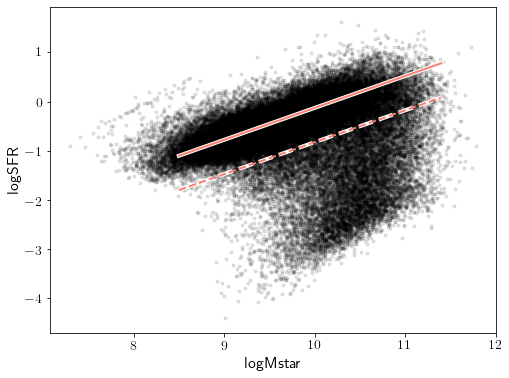

In [20]:
g.plot_ms()

# Comparing LCS vs GSWLC with correct mass and sSFR cuts #

According to Salim+2016, the mass limit is log10Mstar = 9.8, and the ssfr cut is -11.5.

When we apply these cuts and compare the LCS and GSWLC in the SFR-Mstar plane, the LCS galaxies have a similar distribution of stellar masses, but significantly lower SFRs.

We can also compare sSFRs.

In [45]:
#masscut = 8.5
masscut = 9.8
ssfrcut = -11.3

In [19]:
mstar = lcsgsw['logMstar']
sfr = lcsgsw['logSFR']
ssfr = sfr - mstar
gswssfr = gsw['logSFR'] - gsw['logMstar']

NameError: name 'gsw' is not defined

number in core sample =  137
number in external sample =  1159
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.10
p-vale = 0.14328 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.34
p-vale = 0.00000 (prob that samples are from same distribution)


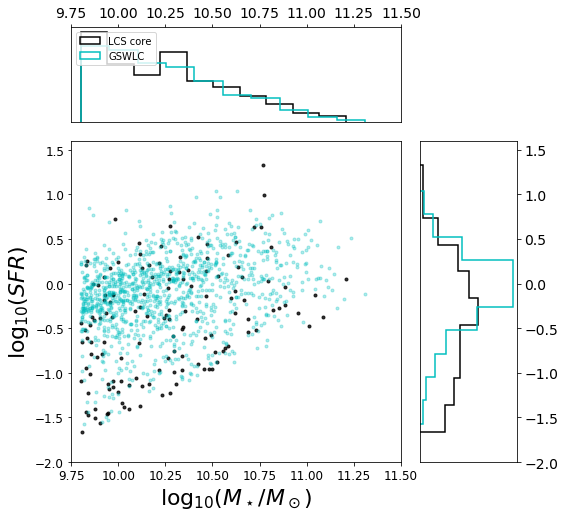

In [77]:
flag1 = lcsgsw['membflag'] &  (lcsgsw['logMstar']> masscut)  & (ssfr > ssfrcut)
flag2 = (gsw['logMstar'] > masscut) & (gswssfr > ssfrcut)  & field_gsw
print('number in core sample = ',sum(flag1))
print('number in external sample = ',sum(flag2))
colormass(mstar[flag1],sfr[flag1],gsw['logMstar'][flag2],gsw['logSFR'][flag2],'LCS core','GSWLC','sfr-mstar-gswlc-field.pdf',ymin=-2,ymax=1.6,xmin=9.75,xmax=11.5,nhistbin=10,ylabel='$\log_{10}(SFR)$',contourflag=False,alphagray=.8)
plt.savefig(homedir+'/research/LCS/plots/lcscore-gsw-sfms.pdf')
plt.savefig(homedir+'/research/LCS/plots/lcscore-gsw-sfms.png')

### LCS Infall vs GSWLC Field ###

**CONCLUSION:**
- LCS infall galaxies have significantly lower SFRs

number in infall sample =  118
number in GSWLC field sample =  1159
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.13
p-vale = 0.04050 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.26
p-vale = 0.00000 (prob that samples are from same distribution)


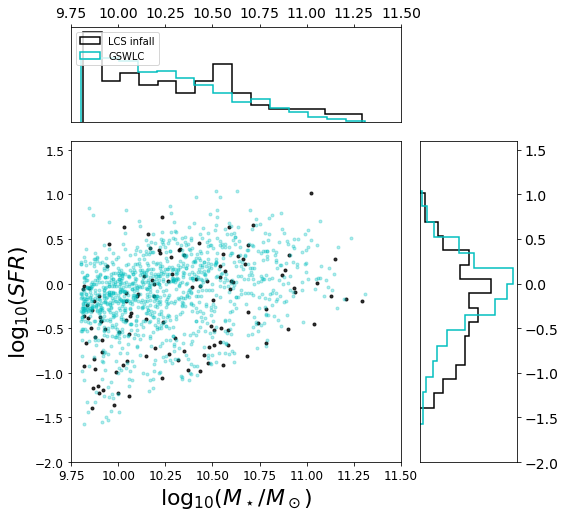

In [78]:
lcsinfall = ~lcsgsw['membflag'] & (lcsgsw['DELTA_V'] < 3.)
mstar = lcsgsw['logMstar']
sfr = lcsgsw['logSFR']
ssfr = sfr - mstar
gswssfr = gsw['logSFR'] - gsw['logMstar']
flag1 = lcsinfall &  (lcsgsw['logMstar']> masscut)  & (ssfr > ssfrcut)
flag2 = (gsw['logMstar'] > masscut) & (gswssfr > ssfrcut)  & field_gsw
print('number in infall sample = ',sum(flag1))
print('number in GSWLC field sample = ',sum(flag2))
colormass(mstar[flag1],sfr[flag1],gsw['logMstar'][flag2],gsw['logSFR'][flag2],'LCS infall','GSWLC','lcsinfall-gswlc-sfms.pdf',ymin=-2,ymax=1.6,xmin=9.75,xmax=11.5,nhistbin=15,ylabel='$\log_{10}(SFR)$',contourflag=False,alphagray=.8)
plt.savefig(homedir+'/research/LCS/plots/lcsinfall-gsw-sfms.pdf')
plt.savefig(homedir+'/research/LCS/plots/lcsinfall-gsw-sfms.png')

### Splitting LCS by Cluster/group vs GSWLC Field ##

**CONCLUSIONS:**

Group members have lower SFRs compared to GSWLC sample.

In [80]:
sigma_split = 600
group = lcsgsw['CLUSTER_SIGMA'] < sigma_split
cluster = lcsgsw['CLUSTER_SIGMA'] > sigma_split

number in core sample =  32
number in external sample =  1159
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.16
p-vale = 0.38027 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.50
p-vale = 0.00000 (prob that samples are from same distribution)


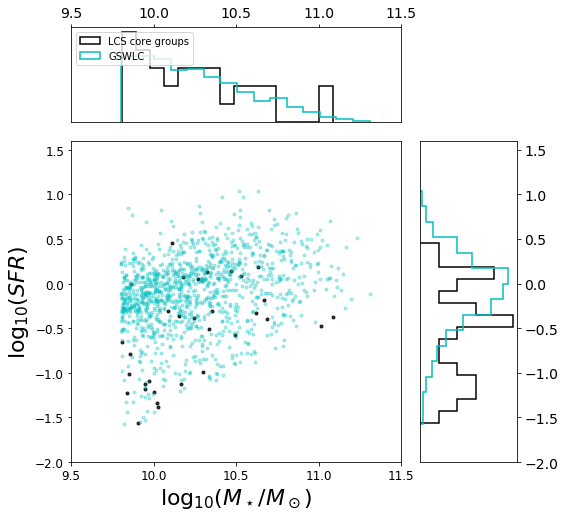

In [81]:
flag1 = lcsgsw['membflag'] &   (lcsgsw['logMstar']> masscut)  & (ssfr > ssfrcut) & group
flag2 = (gsw['logMstar'] > masscut) & (gswssfr > ssfrcut)  & field_gsw
print('number in core sample = ',sum(flag1))
print('number in external sample = ',sum(flag2))
colormass(mstar[flag1],sfr[flag1],gsw['logMstar'][flag2],gsw['logSFR'][flag2],'LCS core groups','GSWLC','sfr-mstar-gswlc-field.pdf',ymin=-2,ymax=1.6,xmin=9.5,xmax=11.5,nhistbin=15,ylabel='$\log_{10}(SFR)$',contourflag=False,alphagray=.8)
plt.savefig(homedir+'/research/LCS/plots/lcsgroup-gsw-sfms.pdf')
plt.savefig(homedir+'/research/LCS/plots/lcsgroup-gsw-sfms.png')

number in core sample =  105
number in external sample =  1159
############################################################# 
KS test comparising galaxies within range shown on the plot

STELLAR MASS
KS Test:
D =   0.12
p-vale = 0.10553 (prob that samples are from same distribution)

COLOR
KS Test:
D =   0.32
p-vale = 0.00000 (prob that samples are from same distribution)


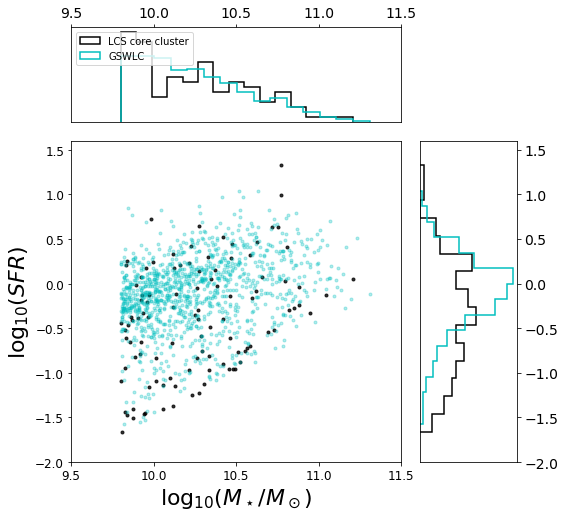

In [82]:
flag1 = lcsgsw['membflag'] &  (lcsgsw['logMstar']> masscut)  & (ssfr > ssfrcut) & cluster
flag2 = (gsw['logMstar'] > masscut) & (gswssfr > ssfrcut)  & field_gsw
print('number in core sample = ',sum(flag1))
print('number in external sample = ',sum(flag2))
colormass(mstar[flag1],sfr[flag1],gsw['logMstar'][flag2],gsw['logSFR'][flag2],'LCS core cluster','GSWLC','sfr-mstar-gswlc-field.pdf',ymin=-2,ymax=1.6,xmin=9.5,xmax=11.5,nhistbin=15,ylabel='$\log_{10}(SFR)$',contourflag=False,alphagray=.8)
plt.savefig(homedir+'/research/LCS/plots/lcscluster-gsw-sfms.pdf')
plt.savefig(homedir+'/research/LCS/plots/lcscluster-gsw-sfms.png')

### Comparing sSFRs of LCS vs GSWLC ###

number in core sample =  137
number in external sample =  1159
KS Test:
D =   0.33
p-vale = 0.00000 (prob that samples are from same distribution)
Anderson-Darling test Test:
D =  39.14
p-vale = 0.04896 (prob that samples are from same distribution)


Text(0, 0.5, '$Normalized \\ Frequency$')

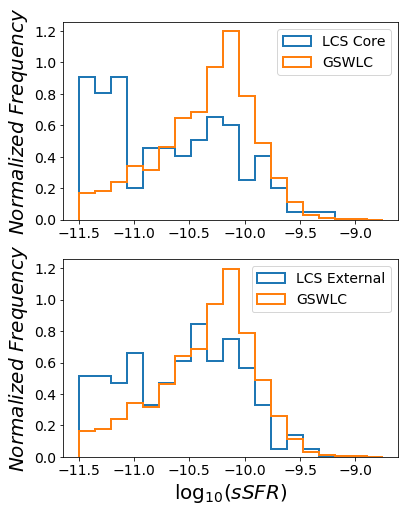

In [99]:
flag1 = lcsgsw['membflag'] &  (lcsgsw['logMstar']> masscut)  & (ssfr > ssfrcut)
flag2 = (gsw['logMstar'] > masscut) & (gswssfr > ssfrcut)  & field_gsw
flag3 = ~lcsgsw['membflag'] &  (lcsgsw['logMstar']> masscut)  & (ssfr > ssfrcut)
print('number in core sample = ',sum(flag1))
print('number in external sample = ',sum(flag2))
ks(ssfr[flag1],gswssfr[flag2])
plt.figure(figsize=(6,8))
plt.subplot(2,1,1)
mybins = np.linspace(-11.5,-8.75,20)
t = plt.hist(ssfr[flag1],bins=mybins,histtype='step',normed=True,lw=2,label='LCS Core')
t = plt.hist(gswssfr[flag2],bins=mybins,histtype='step',normed=True,lw=2,label='GSWLC')
#t = plt.hist(ssfr[flag3],bins=mybins,histtype='step',normed=True,lw=2,label='LCS External')
plt.legend()
#plt.xlabel('$\log_{10}(sSFR)$',fontsize=20)
plt.ylabel('$Normalized \ Frequency$',fontsize=20)
plt.subplot(2,1,2)
mybins = np.linspace(-11.5,-8.75,20)
#t = plt.hist(ssfr[flag1],bins=mybins,histtype='step',normed=True,lw=2,label='LCS Core')
t = plt.hist(ssfr[flag3],bins=mybins,histtype='step',normed=True,lw=2,label='LCS External')
t = plt.hist(gswssfr[flag2],bins=mybins,histtype='step',normed=True,lw=2,label='GSWLC')
plt.legend()
plt.xlabel('$\log_{10}(sSFR)$',fontsize=20)
plt.ylabel('$Normalized \ Frequency$',fontsize=20)

# Still to do #
- bootstrap our external sample, selecting galaxies that have some distribution in SFR-Mass plane as the z0MGS sample.
- this will let us include size in the SF MS plot, using bootstrapped external sample
- incorporate SF in the disk shrinking model.  apply to SF-stellar mass plane. where do objects go in main sequence.  do we reproduce low SF tail seen in core sample.
- what if we split LCS into low and high mass clusters

# Results #

- pop of galaxies with low sSFRs in clusters
- we show that SF is suppressed in infall regions because the external sample is similar in SF-M* to core sample.
- drop in SFRs can be explained by disk shrinking?




# Matching GSWLC-2 and Group Catalogs #

- matched GSWLC-X2 and Tempel+2012 GALAXY group catalog using topcat
  - matching by SDSS objid yielded only a few thousand matches, so I concluded that GSWLC is using DR7 ids whereas tempel is using DR8.  Should look into this more closely b/c (1) why would salim use DR7 in a 2018 paper?  (2) salim does not specifically mention which DR the ids correspond to.
  - matched by RA, DEC, 1 arcsec offset
    - best match, symmetric
    - join 1 and 2
    - 514,186 matches
    - saved as fits-basic:  ~/research/GSWLC/GSWLC-X2-Tempel2012-groups.fits
    
    
    

In [105]:
# read in matched catalog that has GSWLC and Tempel group galaxies
gg = Table(fits.getdata('/home/rfinn/research/GSWLC/GSWLC-X2-Tempel2012-groups.fits'))
gg = gg[gg['redshift'] < 0.04]

In [106]:
# catalog with group info
tgroups = Table(fits.getdata('/home/rfinn/research/sdss-tempel/dr8_ggc.fits',2))

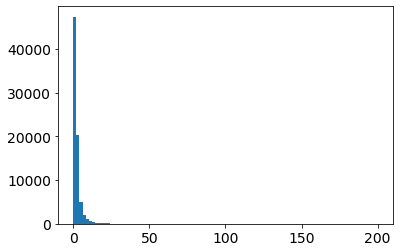

In [109]:
plt.figure()
mybins = np.linspace(0,200,100)
t = plt.hist(tgroups['nrich'],bins=mybins)

In [110]:
gg

id,idcl,nrich,redshift,dist,distcl,ra_1,dec_1,lon,lat,eta,lam,mag_u,mag_g,mag_r,mag_i,mag_z,absmag_u,absmag_g,absmag_r,absmag_i,absmag_z,kcor_u,kcor_g,kcor_r,kcor_i,kcor_z,lumr,w,rank,den1,den2,den4,den8,den16,edgedist,morf,hcearly,dr8objid,dr8specobjid,iddr7,zobs,distcor,flagfc,ObjID,GLXID,plate,MJD,fiber_id,RA_2,DEC_2,Z,chisq,logMstar,logMstar_err,logSFR,logSFR_err,AFUV,AFUV_err,AB,AB_err,AV,AV_err,flag_sed,UV_survey,flag_uv,flag_midir,flag_mgs,Separation
int32,int32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,int16,float32,int64,int64,int32,float32,float32,int16,int64,int64,int16,int32,int16,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,float64
16,1,2,0.104439,306.3157,308.8412,251.16074,28.222496,48.56338,38.87968,20.517765,53.70146,19.29954,17.5629,16.73604,16.37341,16.00028,-18.22351,-20.15187,-20.87932,-21.17534,-21.62663,0.301386,0.263509,0.119865,0.052196,0.040841,1.61335,1.812,1,61.980377,10.358891,3.6414793,5.4820952,3.2901235,10.7944,1,0.08454,1237662302450024704,1898274722890672128,571291,0.104394,308.5762,0,1237662302450024731,3778029842680774769,1686,53472,27,251.16074,28.222484,0.1044,0.66,11.011,0.024,-0.954,0.596,1.248,0.594,0.246,0.04,0.18,0.036,0,2,2,6,1,0.04506360017438818
17,1,2,0.106202,311.3657,308.8412,251.17737,28.137957,48.462173,38.845753,20.438244,53.773224,19.80018,18.22746,17.40944,16.93972,16.64743,-17.78977,-19.47799,-20.26045,-20.60851,-21.02504,0.368287,0.254186,0.17439,0.051671,0.086398,0.9123873,1.812,2,38.71778,8.553819,3.4010985,5.1016965,3.219225,11.0503,1,0.0208,1237662302450024960,1898275547524392960,571320,0.106156,309.1071,1,1237662302450024875,6371478762349924061,1686,53472,30,251.17736,28.137953,0.1062,0.15,10.759,0.062,0.206,0.256,3.002,0.938,0.825,0.171,0.618,0.183,0,1,2,7,1,0.02900791424883003
18,2,3,0.132497,386.2322,387.9647,251.34805,28.46555,48.91581,38.7754,21.000711,53.635235,20.61649,18.66415,17.68126,17.26858,16.89503,-17.54496,-19.69511,-20.49315,-20.82019,-21.28428,0.507843,0.415484,0.174733,0.08776,0.065152,1.130477,2.559,2,61.09396,16.477825,6.3557687,4.2470684,2.2704484,11.3725,1,0.48339,1237659152610492672,1898275822402299904,571684,0.132455,387.90866,0,1237659152610492765,-99,1686,53472,31,251.34804,28.465542,0.1325,0.88,10.788,0.029,-1.346,0.868,1.635,0.715,0.266,0.105,0.18,0.072,0,2,0,0,1,0.049092403110811415
19,2,3,0.133721,389.6974,387.9647,251.35022,28.482853,48.937973,38.77752,21.022816,53.623775,21.14881,18.63368,17.56442,17.14632,16.81766,-17.03879,-19.77514,-20.60835,-20.96562,-21.35924,0.533996,0.465046,0.173089,0.110927,0.062743,1.25702,2.559,1,63.639896,16.667818,6.4811325,4.273681,2.273468,11.2985,0,0.37689,1237659152610492672,1898276647036020736,571688,0.13368,388.02075,0,1237659152610492746,-99,1686,53472,34,251.35021,28.482844,0.1337,0.7,10.856,0.026,-1.387,0.829,2.268,0.804,0.395,0.109,0.27,0.077,0,2,0,0,1,0.0445205440503209
22,2,3,0.133109,387.9639,387.9647,251.33757,28.495668,48.950703,38.79128,21.023628,53.60682,19.96002,18.64266,17.6602,17.29719,17.07429,-18.12773,-19.69588,-20.48092,-20.76989,-21.06878,0.43415,0.394761,0.141441,0.066061,0.028905,1.117814,2.559,3,63.61239,16.57515,6.419016,4.2665396,2.2731717,11.3298,0,0.59931,1237659152610492672,1898277471669741568,571660,0.133067,387.96466,0,1237659152610492720,-99,1686,53472,37,251.33756,28.495651,0.1331,1.22,10.811,0.047,-0.775,0.69,1.688,0.877,0.282,0.107,0.197,0.075,0,2,0,6,1,0.07048647425396412
21,3,2,0.139811,406.8983,405.6975,251.56398,28.53981,49.064293,38.60779,21.321783,53.708347,18.86582,18.08535,17.35154,16.99901,16.8454,-19.0461,-20.22903,-20.86916,-21.10735,-21.39504,0.175765,0.274361,0.12213,0.006402,0.022005,1.598314,2.81,1,60.06423,15.979706,5.129575,3.4810004,